In [1]:
import os
import time
import numpy as np
import scipy as sp
import pandas as pd
from scipy.stats import kendalltau
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
from scipy.spatial.distance import cdist, pdist
from operator import itemgetter
from itertools import chain
from collections import Counter
from pyemd import emd_samples
from src.lexrank import degree_centrality_scores
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from gensim.parsing.preprocessing import preprocess_documents

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from config import *
from helpers import load_data, extract
from visualization import *
from max_semantic_volume_summary import *
from redundancy import *
from relevance import *

from typing import Callable

## Experiments

In [2]:
def execute_experiment(tac, experiment):
    scores = []

    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores, _ = extract(topic)
        scores.append(experiment(document_embs, summary_embs, indices, pyr_scores))
    
    return np.array(scores)

In [3]:
def calculate_scores(indices, metric):
    return np.array([metric(i) for i in indices])


def experiment_average_pairwise_distance(document_embs, summary_embs, indices, pyr_scores):
    metric = lambda i: average_pairwise_distance(summary_embs[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_semantic_volume(document_embs, summary_embs, indices, pyr_scores):
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    metric = lambda i: semantic_volume(summary_pts[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_semantic_spread(document_embs, summary_embs, indices, pyr_scores):
    metric = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_earth_mover_distance(document_embs, summary_embs, indices, pyr_scores):
    metric = lambda i: earth_mover_distance(document_embs, summary_embs[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_lex_rank(document_embs, summary_embs, indices, pyr_scores):
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    metric = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

## Scores

In [4]:
DATASET = DATASETS[0]

In [5]:
tac_encoded = load_data(DATA_DIR, DATASET, encoded=True)
tac         = load_data(DATA_DIR, DATASET, encoded=False)

In [6]:
scores = [
    {
        'label': 'Average pairwise distance',
        'experiment': experiment_average_pairwise_distance 
    },
    {
        'label': 'Semantic volume',
        'experiment': experiment_semantic_volume 
    },
    {
        'label': 'Semantic spread',
        'experiment': experiment_semantic_spread 
    },
#     {
#         'label': 'Earth Mover distance',
#         'experiment': experiment_earth_mover_distance 
#     },
    {
        'label': 'LexRank',
        'experiment': experiment_lex_rank 
    },
]

ptr = ''
print(f'=== Experiments {DATASET} ===\n')
for i,s in enumerate(scores):
    print('   Executing "{}"'.format(s['label']))
    scores[i]['values'] = execute_experiment(tac_encoded, s['experiment'])
    ptr += '   {:30} {:.4}\n'.format(s['label'], np.mean(scores[i]['values']))
    del s['experiment']
print('\n=== Results ===\n')
print(ptr)

=== Experiments TAC2008 ===

   Executing "Average pairwise distance"
   Executing "Semantic volume"
   Executing "Semantic spread"
   Executing "LexRank"

=== Results ===

   Average pairwise distance      -0.01568
   Semantic volume                0.04087
   Semantic spread                0.02699
   LexRank                        0.06146



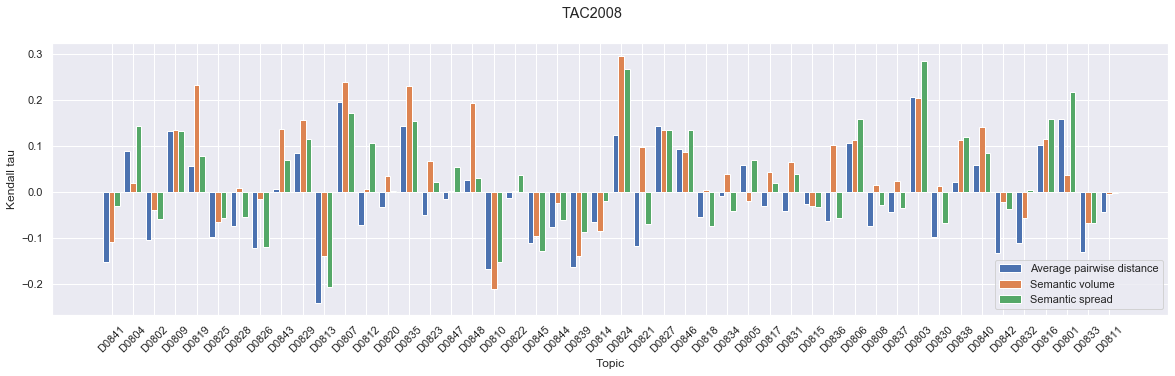

In [7]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(DATASET)
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[:-1])
plt.show()

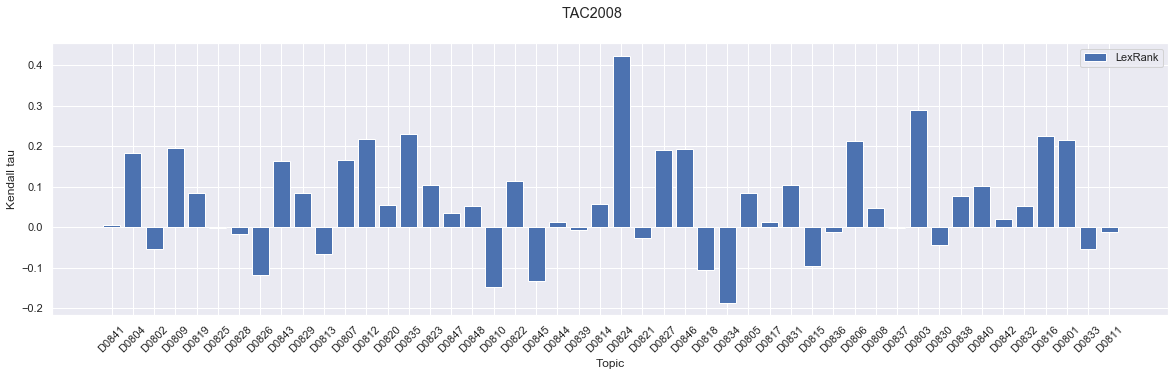

In [8]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(DATASET)
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[-1:])
plt.show()

## Experimental

### Make data

In [11]:
data = []

for topic_id, topic in tac_encoded.items():
    document_embs, summary_embs, indices, pyr_scores, summary_ids = extract(topic)
        
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    
    for p,i in enumerate(indices):
        data.append({
            'topic_id': topic_id,
            'summ_id': summary_ids[p],
            'num_summ_sents': str(i[1]-i[0]),
            'red_1': average_pairwise_distance(summary_embs[i[0]:i[1]]),
            'red_2': semantic_volume(summary_pts[i[0]:i[1]]),
            'red_3': semantic_spread(summary_embs[i[0]:i[1]]),
            'rel_1': lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores),
            'pyr': pyr_scores[p]
        })

df = pd.DataFrame(data)

### Exploratory analysis

In [12]:
def print_sentences(summary):
    for i, sentence in enumerate(summary):
        print('{:3}. {}'.format(i+1, sentence))

In [13]:
# Topic ID with high correlation coefficient
TOPIC_ID = 'D0824'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

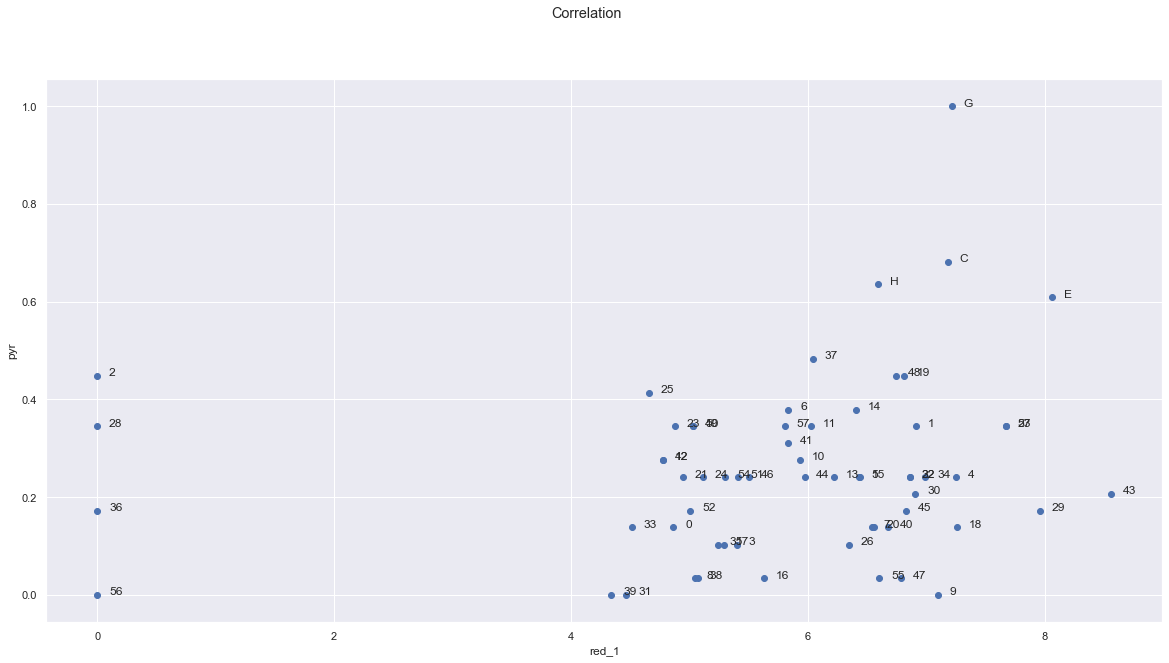

In [14]:
# Scatter plot of metric vs Pyramid score
fig = plt.figure(figsize=(20,10))
fig.suptitle('Correlation')
ax = fig.add_subplot(1,1,1)
plot_corr(ax, df, TOPIC_ID, 'red_1')
plt.show()

In [15]:
# Print summary where the metric and the Pyramid score agree
SUMMARY_ID = int(np.where(summary_ids == 'E')[0])
print_sentences(summaries[indices[SUMMARY_ID,0]:indices[SUMMARY_ID,1]])

  1. The National Health Research Institute and a pharmaceutical company are testing two medications that can treat breast cancer.
  2. One drug can curb a protein active in cancer patients and the other is less likely to trigger cardiovascular disease.
  3. A new U.S.
  4. Sister Study will investigate genetic and environmental causes of breast cancer.
  5. A new drug, aromatase inhibitor, appears to sharply reduce the chances of developing cancer in the other breast.
  6. Researchers say that olive oil may help fight breast cancer.
  7. Oral contraceptives may reduce the risk of breast cancer in high-risk groups.


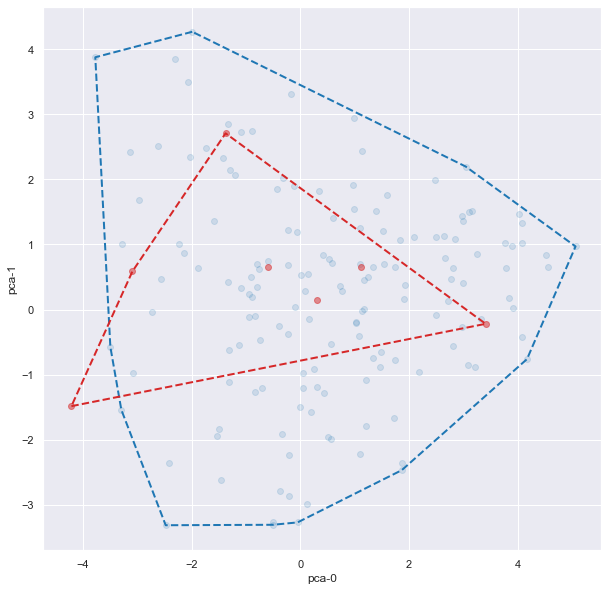

In [16]:
# Plot projection of such summary
document_embs, summary_embs, indices, _, _ = extract(tac_encoded[TOPIC_ID])

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
plot_hull('pca', ax1, '', document_pts, summary_pts[indices[SUMMARY_ID,0]:indices[SUMMARY_ID,1]])
plt.show()

### Why do scores not agree?

In [17]:
# Ratio between the number of summaries with 0 Pyramid score and the ones with > 0 Pyramid score
df[df.pyr == 0].groupby('topic_id').apply(len) / df[df.pyr > 0].groupby('topic_id').apply(len) * 100

topic_id
D0801    14.814815
D0802     1.639344
D0803          NaN
D0804     1.639344
D0805    17.307692
D0806          NaN
D0807          NaN
D0808          NaN
D0809          NaN
D0810     1.639344
D0811     1.639344
D0812    14.814815
D0813     5.084746
D0814     5.084746
D0815     3.333333
D0816          NaN
D0817     3.333333
D0818     5.084746
D0819          NaN
D0820          NaN
D0821     3.333333
D0822     1.639344
D0823          NaN
D0824     6.896552
D0825    21.568627
D0826     3.333333
D0827     6.896552
D0828     1.639344
D0829     1.639344
D0830     6.896552
D0831     5.084746
D0832    12.727273
D0833    16.981132
D0834     1.639344
D0835     8.771930
D0836    10.714286
D0837     8.771930
D0838     1.639344
D0839     1.639344
D0840     6.896552
D0841     1.639344
D0842     1.639344
D0843     6.896552
D0844     1.639344
D0845          NaN
D0846     8.771930
D0847     3.333333
D0848          NaN
dtype: float64

In [18]:
df_tmp = df[df.pyr == 0]
df_tmp.head()

,topic_id,summ_id,num_summ_sents,red_1,red_2,red_3,rel_1,pyr
8,D0841,8,5,7.141869,4.094222,1.197091e+09,8.040533,0.0
100,D0804,38,2,3.977950,0.000000,9.811452e+03,2.930773,0.0
157,D0802,33,3,5.056581,0.461180,3.706337e+05,5.762191,0.0
318,D0825,8,5,7.855877,11.222428,2.781220e+09,8.516494,0.0
319,D0825,9,6,8.955182,4.590404,3.022384e+11,9.270865,0.0


In [19]:
for topic_id, df_group in df_tmp.groupby('topic_id'):
    print(f'=== {topic_id} ===\n')
    for _, row in df_group.iterrows():
        documents, summaries, indices, _, summary_ids = extract(tac[topic_id])
        summary_id = int(np.where(summary_ids == row['summ_id'])[0])
        print(f'   Summary ID: {summary_id}\n')
        print_sentences(summaries[indices[summary_id,0]:indices[summary_id,1]])
        print()

=== D0801 ===

   Summary ID: 1

  1. European airplane maker Airbus "is  likely to discuss before the end of the year" a possible increase in  production capacity of its new super-jumbo A380 aircraft, Airbus'  production chief Gustav Humbert said in a magazine interview  released Tuesday.
  2. The superjumbo Airbus A380, the  world's largest commercial airliner, took off Wednesday into cloudy  skies over southwestern France for its second test flight.
  3. This second test flight is part of a program of tests that will  intensify from here on out, and we're not gonig to make statements  on each phase of the program," Airbus said.
  4. " "

   Summary ID: 9

  1. We are in the process of reviewing the timetable.
  2. Prang said Airbus's management had made that announcement after  analysing the production timetable for the whole project, and that  no one factor could be blamed for the delay.
  3. Emirates Airlines chief executive Tim Clark said that any delay  of more than six months i

### Why do certain summaries have 0 Pyramid score?

In [20]:
df[df.pyr == 0].groupby('topic_id').apply(len).sort_values().head()

topic_id
D0828    1
D0802    1
D0804    1
D0844    1
D0810    1
dtype: int64

In [21]:
TOPIC_ID = 'D0802'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

In [22]:
df_tmp = df[df.topic_id == TOPIC_ID].sort_values(by='pyr')

In [23]:
# Worst summary
SUMMARY_ID = int(np.where(summary_ids == df_tmp.iloc[0].summ_id)[0])
print_sentences(summaries[indices[SUMMARY_ID,0]:indices[SUMMARY_ID,1]])

  1. STOCKHOLM, June 6  A two week conference on the Antarctic, focusing on environmental, climate change and tourism issues, opened on Monday with representatives of 50 governments, researchers and experts, the Swedish hosts said.
  2. The conference, which runs to June 17, comes amid fresh warnings from scientists about the effect of climate change on Antarctica, the fifth largest continent in the world, which contains more than 90 percent of the world's ice.
  3. Sweden hopes that the meeting will result in a special protocol on responsibility and insurance in case of major accidents in the Antarctic, such as oil spills.


In [24]:
# Best summary
SUMMARY_ID = int(np.where(summary_ids == df_tmp.iloc[-1].summ_id)[0])
print_sentences(summaries[indices[SUMMARY_ID,0]:indices[SUMMARY_ID,1]])

  1. Collapse of coastal Antarctic ice shelves accelerated eight-fold the seaward flow of inland glaciers, raising sea levels: Larsen A (1995), Wilkins (1998), Larsen B (2002), Larsen C (this century).
  2. Currents undermine the Ross and Ronne ice shelves, enabling ice flows from deep within the West Antarctic ice sheet.
  3. Arctic permafrost thawed; glaciers and sea ice retreated.
  4. In 30 years the Arctic ice cap's area shrank by 10%, its thickness by 42%, opening shorter maritime routes when Arctic sea ice disappears in future summers.
  5. Siberian lakes disappeared.
  6. Indigenous cultures and glacier tourism suffered.
  7. Bird migrations shifted.
  8. Northern Hemisphere weather will worsen.


In [25]:
import clausiepy as clausie
clauses = clausie.clausie("Sweden hopes that the meeting will result in a special protocol on responsibility and insurance in case of major accidents in the Antarctic, such as oil spills.")
propositions = clausie.extract_propositions(clauses)
clausie.print_propositions(propositions)

([Sweden], [hopes], [], [], [that, the, meeting, will, result, in, a, special, protocol, on, responsibility, and, insurance, in, case, of, major, accidents, in, the, Antarctic, ,, such, as, oil, spills], [])
([Sweden], [hopes], [], [], [that, the, meeting, will, result, in, a, special, protocol, on, responsibility, and, insurance, in, case, of, major, accidents, in, the, Antarctic, ,, such, as, oil, spills], [in, a, special, protocol, on, responsibility, and, insurance, in, case, of, major, accidents, in, the, Antarctic, ,, such, as, oil, spills])
([Sweden], [hopes], [], [], [that, the, meeting, will, result, in, a, special, protocol, on, responsibility, and, insurance, in, case, of, major, accidents, in, the, Antarctic, ,, such, as, oil, spills], [on, responsibility, and, insurance])
([Sweden], [hopes], [], [], [that, the, meeting, will, result, in, a, special, protocol, on, responsibility, and, insurance, in, case, of, major, accidents, in, the, Antarctic, ,, such, as, oil, spills], 

### Regression analysis

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,3:-1], df.iloc[:,-1], stratify=df.iloc[:,0])

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

estimator = Ridge()

parameters = { 'alpha': np.linspace(0, 1, 100) }

cv = GridSearchCV(estimator, parameters, scoring='neg_mean_squared_error', cv=10)

cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.best_score_)

{'alpha': 0.3434343434343435}
-0.035953789059709


In [21]:
best_estimator = cv.best_estimator_
best_estimator.score(X_test, y_test)

0.09440638358416165

### Combination of Relevance and Redundancy metrics

In [22]:
for alpha in np.linspace(0,1,10):

    def experiment_comb(document_embs, summary_embs, indices, pyr_scores):
        metric_1 = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
        scores_1 = calculate_scores(indices, metric_1)

        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
        metric_2 = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
        scores_2 = calculate_scores(indices, metric_2)

        scores = (1-alpha) * scores_1 + alpha * scores_2

        return kendalltau(pyr_scores, scores)[0]

    print(np.mean(execute_experiment(tac_encoded, experiment_comb)))

0.1608747108305918
0.1608979399420694
0.1608979399420694
0.1608979399420694
0.16092551325990417
0.16092551325990417
0.16092551325990417
0.16092551325990417
0.16095283924824696
0.19811498302816635


### Exporting best summaries for all datasets

In [25]:
for dataset in DATASETS:
    tac = load_data(DATA_DIR, dataset, encoded=True)
    print(f'{dataset}')
    
    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores, summary_ids = extract(topic)

        m = np.argsort(-pyr_scores)

        embeddings = {
            'tag': f'{DATASET}:{topic_id}:System Summaries:BERT',
            'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
            'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
        }

        make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

TAC2008
TAC2009


# Plotting BERT

In [70]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid scores
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

## System Summaries

### TensorBoard

In [12]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:System Summaries:BERT',
    'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
    'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

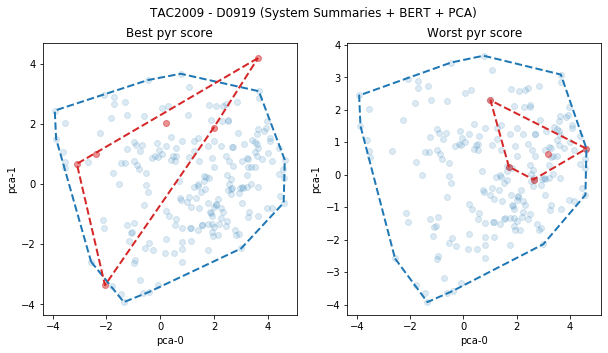

In [13]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + PCA)')
ax1 = fig.add_subplot(1,2,1)
plot('pca', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('pca', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 473 samples in 0.015s...
[t-SNE] Computed neighbors for 473 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 473 / 473
[t-SNE] Mean sigma: 2.878953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.332146
[t-SNE] KL divergence after 2400 iterations: 0.672893


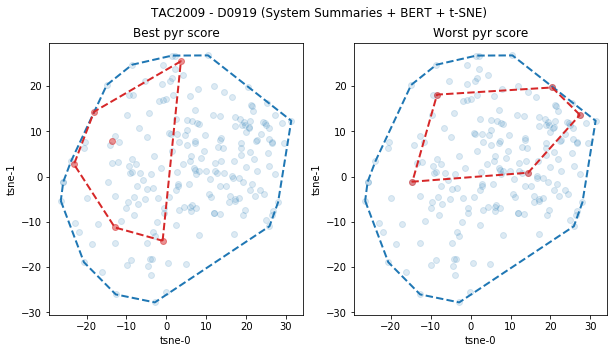

In [14]:
document_pts, summary_pts = project_tsne(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + t-SNE)')
ax1 = fig.add_subplot(1,2,1)
plot('tsne', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('tsne', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

## Extractive Summarization by Maximizing Semantic Volume

In [15]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [16]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:BERT',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

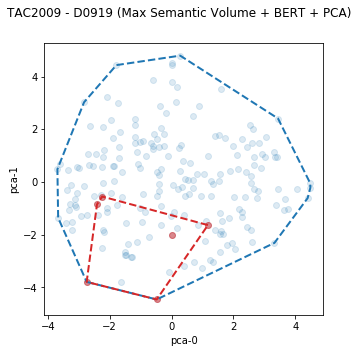

In [17]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.004s...
[t-SNE] Computed neighbors for 208 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 2.745973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.173157
[t-SNE] KL divergence after 1050 iterations: 0.777134


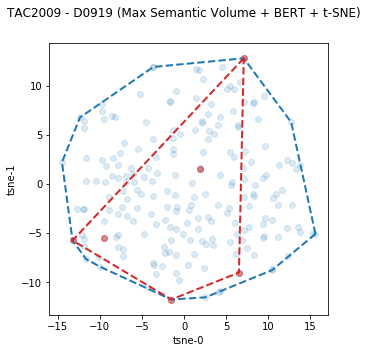

In [18]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Plotting SVD

In [19]:
### Load
tac = load_data(DATASET, encoded=False)

### Extract
topic = tac[TOPIC]
documents, summaries, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

### Count bigrams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=True)
X = vectorizer.fit_transform(documents)

# If bigram b is present in s_i,
# we let s_i,b be the number of documents
# in the corpus that contain bigram b, and
# zero otherwise.
nd = X.sum(axis=0)
S = X.multiply(nd)

### Decompose
U, Sigma, VT = randomized_svd(S, n_components=100, n_iter=5, random_state=42)

# We then perform singular value decomposition (SVD)
# on S. We use U_K as the sentence representations.

In [21]:
document_embs = U

## Extractive Summarization by Maximizing Semantic Volume

In [22]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [23]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:SVD',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

###  PCA

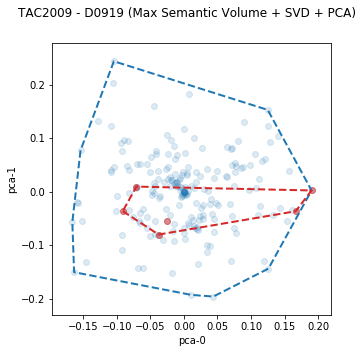

In [24]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.001s...
[t-SNE] Computed neighbors for 208 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.240379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.293152
[t-SNE] KL divergence after 1400 iterations: 1.076915


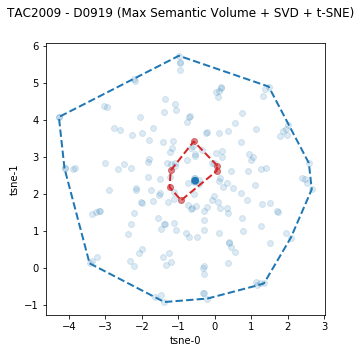

In [25]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Interactive plot BERT

In [26]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

### PCA

In [27]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[indices[m[i],0]:indices[m[i],1]], f'sum-{i+1}') for i in range(len(m))], ignore_index=True)

In [28]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…